In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
from simulation import minimal_model as mm
from surrogate import neural_network

from sampling import grid, random
from visualise import stream, surface

2024-05-06 23:13:45.377459: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 23:13:46.402959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data generation

In [3]:
n_samples = 1000
# Minimal model testing
g = 1.7
B_lim, D_lim = 2.9, 0.4

In [4]:
# RS = random.RandomStack()
# D_grid, B_grid = RS.sample_stack([(0, D_lim), (0, B_lim)], 100)

In [5]:
# Grid search
EG = grid.EqualStack()
D_grid, B_grid = EG.sample_stack([(0, D_lim), (0, B_lim)], n_samples)

In [6]:
# Run miminal model
dB_dt, dD_dt = mm.step(B_grid, D_grid, g, warm_up=0)

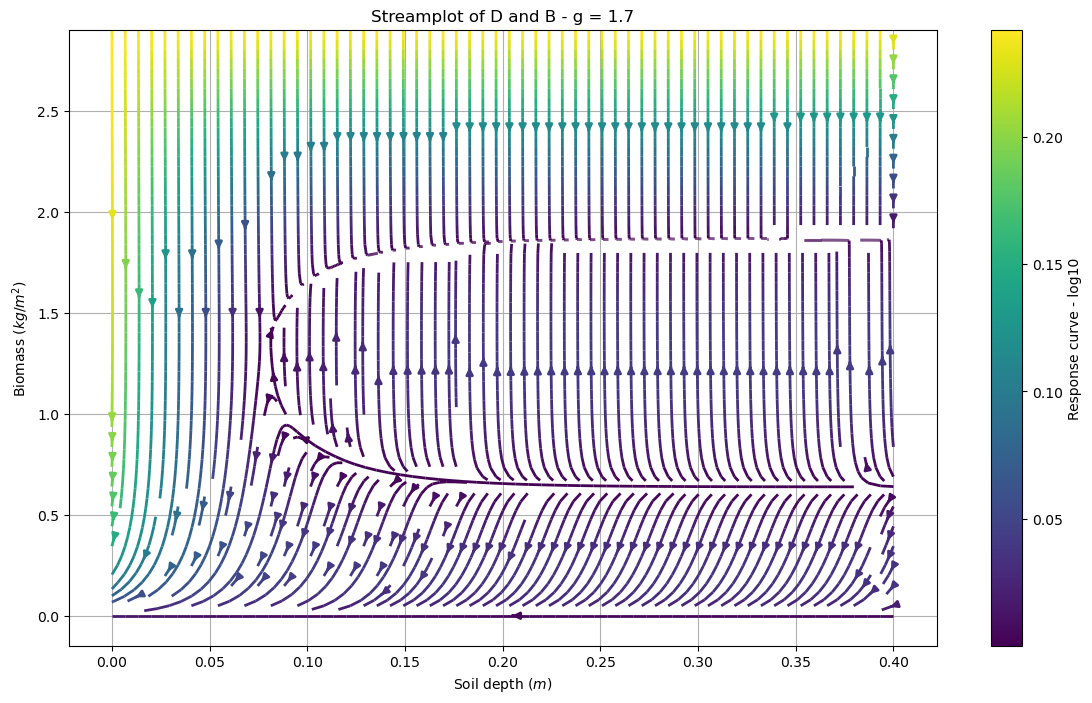

In [7]:
stream.show(D_grid, B_grid, dD_dt, dB_dt, g)

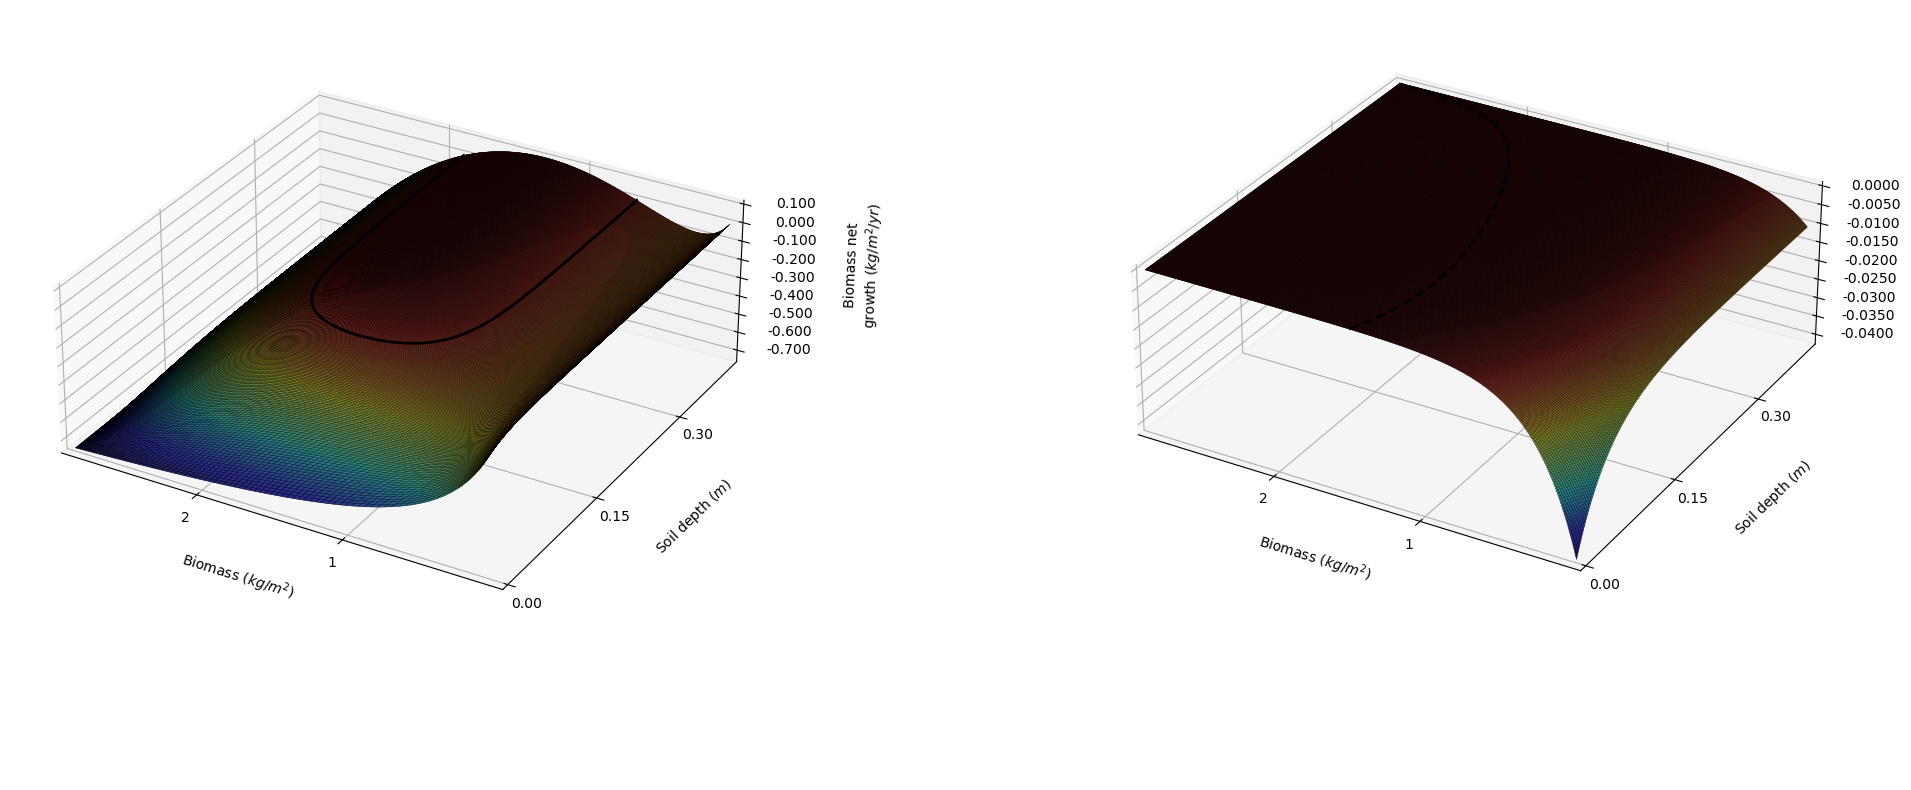

In [8]:
surface.show(D_grid, B_grid, dD_dt, dB_dt, D_lim, B_lim)

In [9]:
#  ['B', 'D', 'g', 'dB_dt', 'dD_dt']
X = np.column_stack([B_grid.flatten(), D_grid.flatten(), np.repeat(g, (n_samples*n_samples))])
y = np.column_stack([dB_dt.flatten(), dD_dt.flatten()])
X.shape, y.shape

((1000000, 3), (1000000, 2))

# Neural network

## Training

In [10]:
# NN = neural_network.NeuralNetwork(uid="20240506_1840")
NN = neural_network.NeuralNetwork()
NN.paths['model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

NN.train(X_train, y_train, X_val, y_val)

Starting Neural Network training...
Epoch 1/100


2024-05-06 23:14:37.288544: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-06 23:14:37.290086: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.2464 - val_loss: 0.9249
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8964 - val_loss: 0.8561
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8534 - val_loss: 0.8347
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8391 - val_loss: 0.8357
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8450 - val_loss: 0.8716
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8512 - val_loss: 0.8576
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8416 - val_loss: 0.8245
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8340 - val_loss: 0.8313
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8105 - val_loss: 0.8096
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8054 - val_loss: 0.8082
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.8065 - val_loss: 0.8079
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━

In [11]:
# import json
# uid = NN.uid
# with open(f"data/history/{uid}.json", "r") as f:
#     history = json.load(f)
# history.keys()

In [12]:
# plt.title(f"Training history\n\nLR: {NN.hp['learning_rate']}, BS: {NN.hp['batch_size']}")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.plot(history['loss'], label="Loss")
# plt.plot(history['val_loss'], label="Val Loss")
# plt.legend()
# plt.show()

## Predition

In [13]:
B_true, D_true = EG.sample_stack([(0, D_lim), (0, B_lim)], 100)
X = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (100*100))))

dB_dt, dD_dt = mm.step(B_grid, D_grid, g, warm_up=0)
Y = np.column_stack((dB_dt.flatten(), dD_dt.flatten()))
X.shape, Y.shape

((1000000, 3), (1000000, 2))

In [14]:
y_pred = NN.model.predict(X)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 24s 752us/step


In [15]:
mean_squared_error(Y, y_pred)

0.004806770410717706

In [16]:
pred_dB_dt, pred_dD_dt,  = y_pred.reshape(2, n_samples, n_samples)

In [17]:
D_grid.shape, B_grid.shape, pred_dD_dt.shape, pred_dB_dt.shape

((1000, 1000), (1000, 1000), (1000, 1000), (1000, 1000))

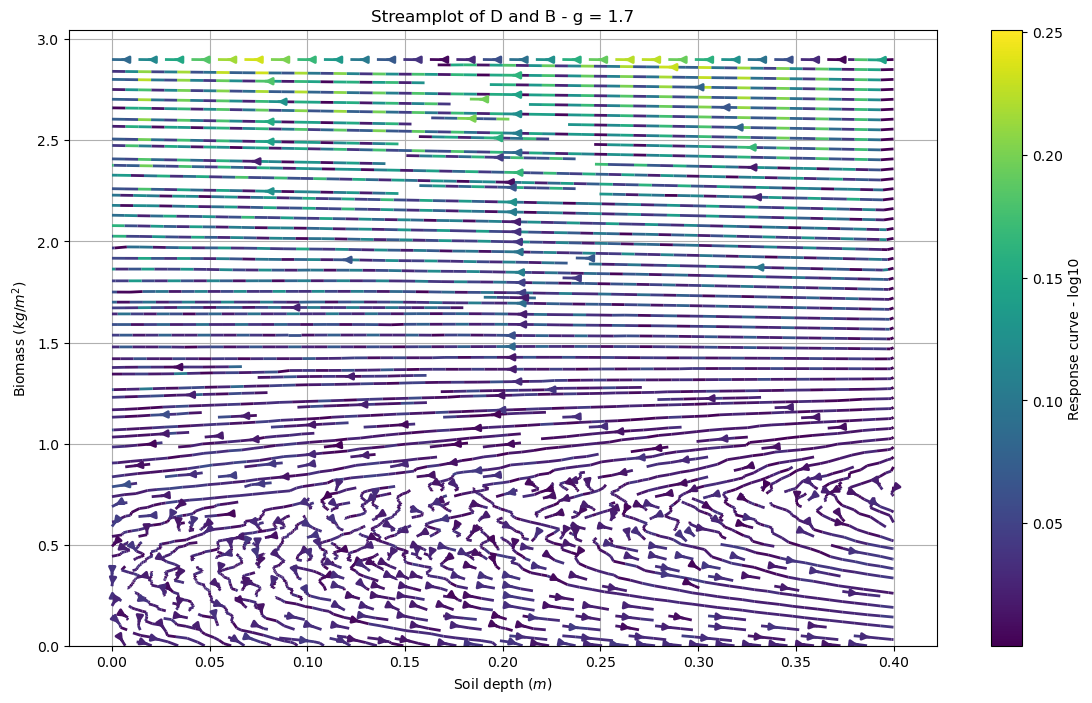

In [18]:
stream.show(D_grid, B_grid, pred_dD_dt, pred_dB_dt, g)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (20007,) + inhomogeneous part.

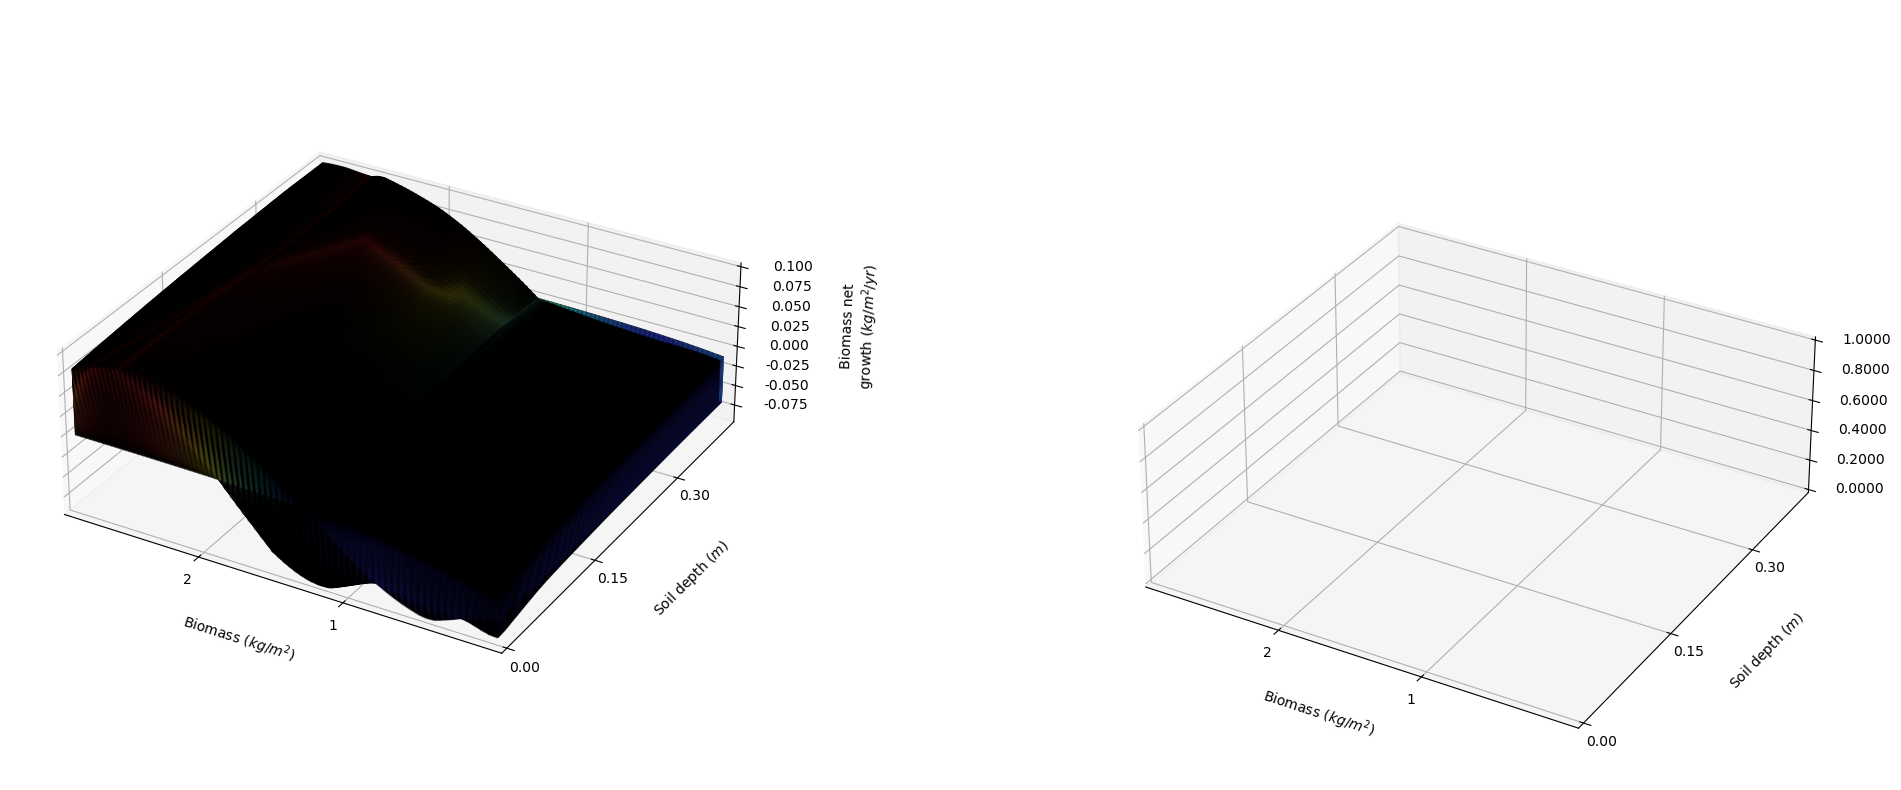

In [19]:
surface.show(D_grid, B_grid, pred_dD_dt, pred_dB_dt, D_lim, B_lim)